In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 17})
import folium
import re
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

class DataFrame(object):

    def __init__(self,file_path):
        """Create df object
        Parameters
        ----------
        file_path: takes in a file path to raw data
        """
        self.file_path = file_path
        
    def clean(self):
        '''
        Parameters
            self: self
        Returns
            a cleaned df
        '''
        df = pd.read_csv(self.file_path,encoding='latin1')
        df.dropna(inplace=True)
        df.drop(['permalink','region','founded_month','founded_quarter'],axis=1,inplace=True)
        df['founded_at'] = pd.to_datetime(df['founded_at'],errors='coerce')
        df['first_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['last_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['founded_year'] = df['founded_year'].astype('int64')
        df.drop(df[df['country_code']=='CAN'].index,inplace=True)
        df['funding_total_usd'] = df[' funding_total_usd '].apply(lambda x: x.replace(' ',''))\
            .apply(lambda x: x.replace(',',''))
        df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: x.replace('-','0'))
        df['funding_total_usd'] = df['funding_total_usd'].astype('int64')
        df['market'] = df[' market '].apply(lambda x: x.replace(' ','')) 
        df.drop([' market ',' funding_total_usd ','country_code','homepage_url','name','city','last_funding_at', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H','category_list'],axis=1,inplace=True)
        return df

def feature_engineer(df):
    '''
    Parameters
        df: Takes in a pandas data frame
    Returns
        a data frame with engineered features
    '''
    df['time_to_funding'] = abs((df['first_funding_at']-df['founded_at']).dt.days)
    test_list = list(df['market'].value_counts()\
        .rename_axis('market').reset_index(name='counts')[:20]['market'])
    df.loc[~df["market"].isin(test_list), "market"] = "Other"
    df.dropna(inplace=True)
    return df

def add_finance(symbol,df):
    '''
    Parameters
        symbol: stock ticker
        df: data frame to add 
    Returns
        a data frame with engineered features
    '''
    finance = yf.Ticker(symbol)
    fin_df = finance.history(period="max")
    fin_df['avg']=(fin_df['Open']+fin_df['Close'])/2
    fin_df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'],axis=1,inplace=True)
    fin_df['first_funding_at'] = fin_df.index
    
    no_finance_data = list(clean_feat_df[clean_feat_df['first_funding_at']<fin_df['first_funding_at'].min()].index)
    df.drop(no_finance_data,inplace=True)
    df.set_index('first_funding_at')
    df = df.merge(fin_df,on='first_funding_at')
    return df

In [3]:
intial_df = DataFrame('../../../Downloads/investments_VC.csv').clean()
clean_feat_df=feature_engineer(intial_df)
clean_feat_df=add_finance('^VIX',clean_feat_df)

#change funding from to dollars to ones and zeros
funding_type_df = clean_feat_df.loc[:,'seed':'product_crowdfunding']\
    .apply(lambda x: x>0).astype('int64')
funding_type_df.drop('undisclosed',axis=1,inplace=True)

#make dummies
col_list = ['Advertising', 'Analytics', 'Biotechnology', 'CleanTechnology',
   'Consulting', 'CuratedWeb', 'E-Commerce', 'Education',
   'EnterpriseSoftware', 'Finance', 'Games', 'Hardware+Software',
   'HealthCare', 'HealthandWellness', 'Manufacturing', 'Mobile',
   'Security', 'Semiconductors', 'SocialMedia', 'Software','Other']
market_dummies = pd.get_dummies(clean_feat_df['market']).reindex(columns=col_list)
state_dummies = pd.get_dummies(clean_feat_df['state_code'])

# set targets as ones and zeros
clean_feat_df['status'] = clean_feat_df['status'].apply(lambda x: x.replace('operating','0'))\
    .apply(lambda x: x.replace('acquired','1')).apply(lambda x: x.replace('closed','0'))
clean_feat_df['status'] = clean_feat_df['status'].astype('int64')

#set X and Y, test train split and SMOTE                           
X =market_dummies.iloc[:,:20].join(state_dummies.iloc[:,:50])\
    .join(clean_feat_df['time_to_funding']).join(clean_feat_df['avg']).join(funding_type_df).values
y=clean_feat_df['status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

#build logisitic model
log_model = LogisticRegression(solver="lbfgs",max_iter=300)
log_model.fit(X_train, y_train)
y_predict_log = log_model.predict(X_test)

#build random forest model
rf = RandomForestClassifier(max_features=42, n_estimators=100)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

#build extra trees model
extra = ExtraTreesClassifier(n_estimators=100)
extra.fit(X_train, y_train)
y_predict_extra =extra.predict(X_test)

#build gradient boosted model
gradient= GradientBoostingClassifier(random_state=1)
gradient.fit(X_train, y_train)
y_predict_gradient = gradient.predict(X_test)

In [5]:
invest = 10000
yearly_return = .27
hold_per=8

profit_curve_rf = []
cum_profit_rf = 0
sorted_y = y_test[(np.argsort(rf.predict_proba(X_test)[:,1])[::-1])]
for i in sorted_y:
    if i==1:
        cum_profit_rf += (((1+yearly_return)**hold_per)*invest)
        profit_curve_rf.append(cum_profit_rf)
    else:
        cum_profit_rf -=invest
        profit_curve_rf.append(cum_profit_rf)
        
profit_curve_log = []
cum_profit_log = 0
sorted_y_log = y_test[(np.argsort(log_model.predict_proba(X_test)[:,1])[::-1])]
for i in sorted_y_log:
    if i==1:
        cum_profit_log += (((1+yearly_return)**hold_per)*invest)
        profit_curve_log.append(cum_profit_log)
    else:
        cum_profit_log -=invest
        profit_curve_log.append(cum_profit_log)

profit_curve_extra = []
cum_profit_extra = 0
sorted_y_extra = y_test[(np.argsort(extra.predict_proba(X_test)[:,1])[::-1])]
for i in sorted_y_extra:
    if i==1:
        cum_profit_extra += (((1+yearly_return)**hold_per)*invest)
        profit_curve_extra.append(cum_profit_extra)
    else:
        cum_profit_extra -=invest
        profit_curve_extra.append(cum_profit_extra)

profit_curve_gradient = []
cum_profit_gradient = 0
sorted_y_gradient = y_test[(np.argsort(gradient.predict_proba(X_test)[:,1])[::-1])]
for i in sorted_y_gradient:
    if i==1:
        cum_profit_gradient += (((1+yearly_return)**hold_per)*invest)
        profit_curve_gradient.append(cum_profit_gradient)
    else:
        cum_profit_gradient -=invest
        profit_curve_gradient.append(cum_profit_gradient)

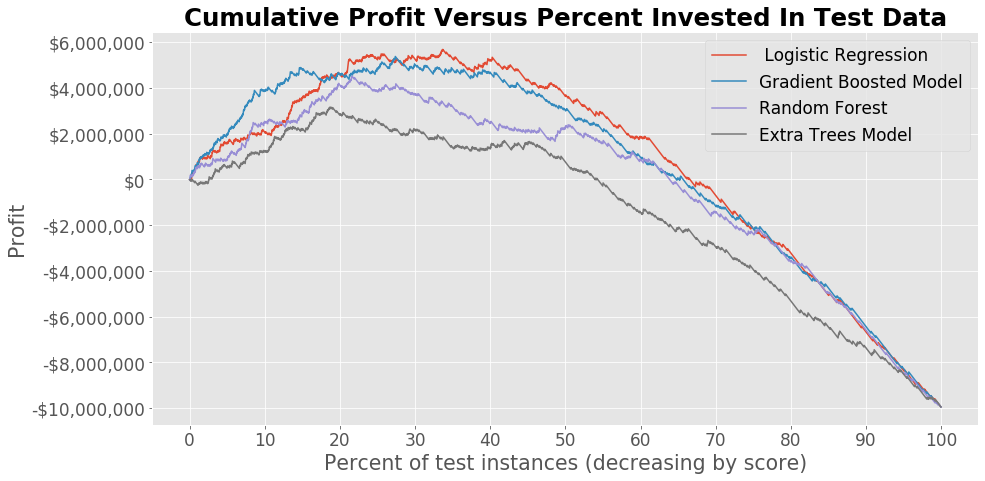

In [359]:
fig,ax = plt.subplots(figsize=(14,7))
ax.plot(profit_curve_log,label=' Logistic Regression')
ax.plot(profit_curve_gradient,label='Gradient Boosted Model')
ax.plot(profit_curve_rf,label='Random Forest')
ax.plot(profit_curve_extra,label='Extra Trees Model')
#ax.axvline(np.argsort(profit_curve_log)[4303],ls=':',label='Logistic Regression Maximum' )
ax.legend()
ax.set_yticks([-10000000,-8000000,-6000000,-4000000,-2000000,0,2000000,4000000,6000000])
ax.set_yticklabels(['-$10,000,000','-$8,000,000','-$6,000,000','-$4,000,000','-$2,000,000','$0','$2,000,000','$4,000,000','$6,000,000'])
ax.set_xticks(np.linspace(0,4304,11))
ax.set_xticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax.set_xlabel('Percent of test instances (decreasing by score)')
ax.set_ylabel('Profit')
ax.set_title('Cumulative Profit Versus Percent Invested In Test Data',fontweight='bold')
#ax.annotate('Investment Costs $14,500,000', xy=(1450, 5685560.9026), xytext=(1800,-4000000),
            #arrowprops=dict(facecolor='black', shrink=0.05),)
plt.tight_layout()
plt.savefig('../images/all_profit_curve',dpi=500)

In [39]:
1450*10000

14500000

In [40]:
profit_curve_log[1450]
#5,685,560

5685560.902664937

In [226]:
def eval_model(model, X_test, y_test,threshold):
    predicted_proba = model.predict_proba(X_test)
    preds = (predicted_proba [:,1] >= threshold).astype('int')
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print('===ACCURACY===')
    print(acc)
    print('===RECALL===')
    print(rec)
    print('===PRECISION===')
    print(prec)
    print('===F1===')
    print(f1)

In [342]:
eval_model(rf,X_test,y_test,.19)

===ACCURACY===
0.7671933085501859
===RECALL===
0.41784037558685444
===PRECISION===
0.19098712446351931
===F1===
0.2621502209131075


In [343]:
eval_model(log_model,X_test,y_test,.53)

===ACCURACY===
0.6784386617100372
===RECALL===
0.6126760563380281
===PRECISION===
0.17635135135135135
===F1===
0.2738719832109129


In [338]:
eval_model(extra,X_test,y_test,.19)

===ACCURACY===
0.7815985130111525
===RECALL===
0.3333333333333333
===PRECISION===
0.17794486215538846
===F1===
0.23202614379084968


In [344]:
eval_model(gradient,X_test,y_test,.26)

===ACCURACY===
0.7402416356877324
===RECALL===
0.48826291079812206
===PRECISION===
0.18772563176895307
===F1===
0.27118644067796616


In [340]:
thresh_list= np.linspace(0,1,101)
profit = []
log_profit = []
extra_profit = []
gradient_profit = []
invest = 10000
yearly_return = .27
hold_per=8
for val in thresh_list:
    threshold = val
    
    predicted_proba = rf.predict_proba(X_test)
    preds = (predicted_proba [:,1] >= threshold).astype('int')
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    profit.append(round((tp/(tn+fp+fn+tp))*(((1+yearly_return)**hold_per)*invest)-((fp/(tn+fp+fn+tp))*invest),2))

    predicted_proba_log = log_model.predict_proba(X_test)
    preds_log = (predicted_proba_log [:,1] >= threshold).astype('int')
    log_tn, log_fp, log_fn, log_tp = confusion_matrix(y_test, preds_log).ravel()
    log_profit.append(round((log_tp/(log_tn+log_fp+log_fn+log_tp))*(((1+yearly_return)**hold_per)*invest)-((log_fp/(log_tn+log_fp+log_fn+log_tp))*invest),2))
    
    predicted_proba_extra = extra.predict_proba(X_test)
    preds_extra = (predicted_proba_extra [:,1] >= threshold).astype('int')
    extra_tn, extra_fp, extra_fn, extra_tp = confusion_matrix(y_test, preds_extra).ravel()
    extra_profit.append(round((extra_tp/(extra_tn+extra_fp+extra_fn+extra_tp))*(((1+yearly_return)**hold_per)*invest)-((extra_fp/(extra_tn+extra_fp+extra_fn+extra_tp))*invest),2))

    predicted_proba_gradient = gradient.predict_proba(X_test)
    preds_gradient = (predicted_proba_gradient [:,1] >= threshold).astype('int')
    gradient_tn, gradient_fp, gradient_fn, gradient_tp = confusion_matrix(y_test, preds_gradient).ravel()
    gradient_profit.append(round((gradient_tp/(gradient_tn+gradient_fp+gradient_fn+gradient_tp))*(((1+yearly_return)**hold_per)*invest)-((gradient_fp/(gradient_tn+gradient_fp+gradient_fn+gradient_tp))*invest),2))

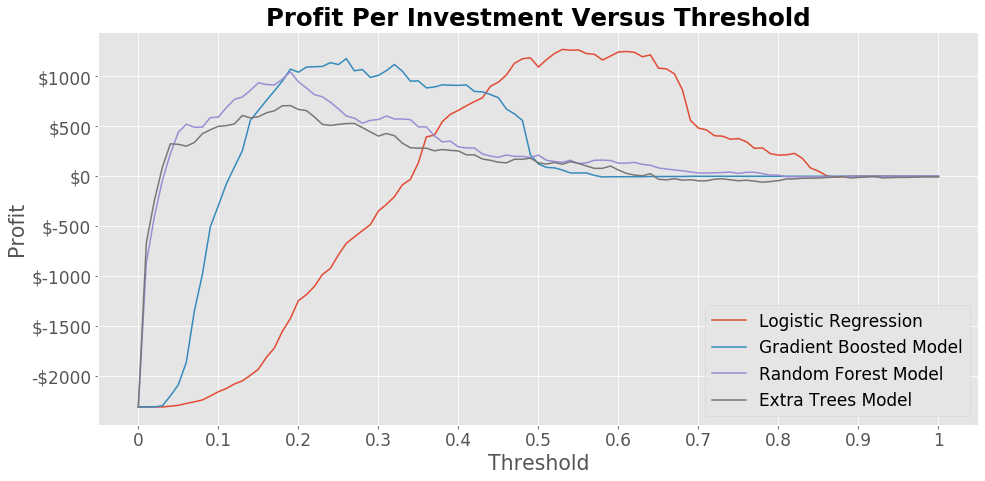

In [355]:
fig,ax = plt.subplots(figsize=(14,7))
ax.plot(log_profit,label='Logistic Regression')
ax.plot(gradient_profit,label='Gradient Boosted Model')
ax.plot(profit,label='Random Forest Model')
ax.plot(extra_profit,label='Extra Trees Model')
ax.set_xlabel('Threshold')
ax.set_ylabel('Profit')
ax.set_title('Profit Per Investment Versus Threshold',fontweight='bold')
ax.set_yticks([-2000,-1500,-1000,-500,0,500,1000])
ax.set_yticklabels(['-$2000','$-1500','$-1000','$-500','$0','$500','$1000'])
ax.legend()
plt.xticks([0,10,20,30,40,50,60,70,80,90,100],labels=['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'])
plt.tight_layout()
plt.savefig('../images/profit_threshold',dpi=500)

In [108]:
thresh_list[np.argsort(extra_profit)[100]]

0.19

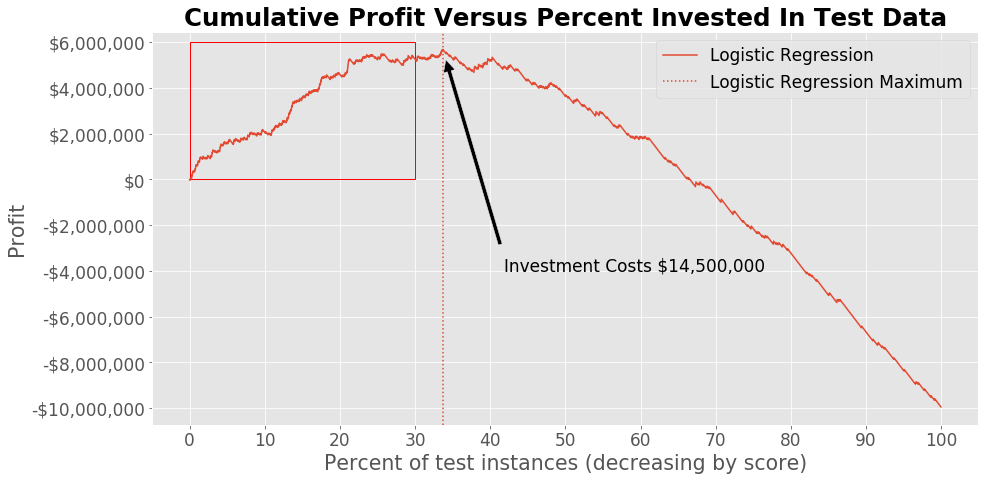

In [356]:
fig,ax = plt.subplots(figsize=(14,7))
ax.plot(profit_curve_log,label='Logistic Regression')
# ax.plot(profit_curve_gradient,label='Gradient Boosted Model')
# ax.plot(profit_curve_rf,label='Random Forest')
# ax.plot(profit_curve_extra,label='Extra Trees Model')
ax.axvline(np.argsort(profit_curve_log)[4303],ls=':',label='Logistic Regression Maximum' )
ax.legend()
ax.set_yticks([-10000000,-8000000,-6000000,-4000000,-2000000,0,2000000,4000000,6000000])
ax.set_yticklabels(['-$10,000,000','-$8,000,000','-$6,000,000','-$4,000,000','-$2,000,000','$0','$2,000,000','$4,000,000','$6,000,000'])
ax.set_xticks(np.linspace(0,4304,11))
ax.set_xticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax.set_xlabel('Percent of test instances (decreasing by score)')
ax.set_ylabel('Profit')
ax.set_title('Cumulative Profit Versus Percent Invested In Test Data',fontweight='bold')
ax.annotate('Investment Costs $14,500,000', xy=(1450, 5685560.9026), xytext=(1800,-4000000),
            arrowprops=dict(facecolor='black', shrink=0.05),)
rect = patches.Rectangle((0,0),1291.2,6000000,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.tight_layout()
plt.savefig('../images/zoom_profit_curve',dpi=500)

In [84]:
x=754
profit_curve_log[x]<profit_curve_gradient[x]

True

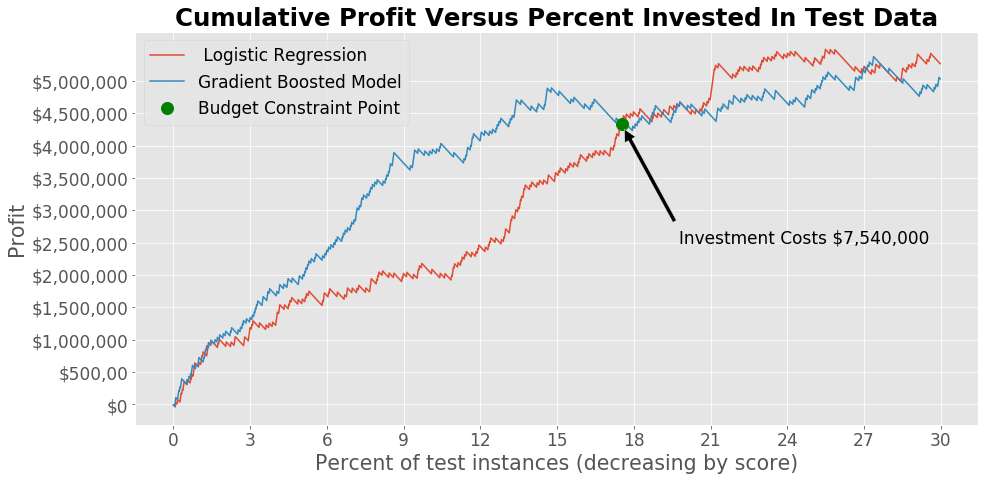

In [357]:
fig,ax = plt.subplots(figsize=(14,7))
ax.plot(profit_curve_log[:1291],label=' Logistic Regression')
ax.plot(profit_curve_gradient[:1291],label='Gradient Boosted Model')
plt.plot([754], [4334310.838875904], 'go',markersize=12,label='Budget Constraint Point')
ax.legend()
ax.set_yticks([0,500000,1000000,1500000,2000000,2500000,3000000,3500000,4000000,4500000,5000000])
ax.set_yticklabels(['$0','$500,00','$1,000,000','$1,500,000','$2,000,000','$2,500,000',
                    '$3,000,000','$3,500,000','$4,000,000','$4,500,000','$5,000,000'])
ax.set_xticks(np.linspace(0,1291.2,11))
ax.set_xticklabels(['0','3','6','9','12','15','18','21','24','27','30'])
ax.set_xlabel('Percent of test instances (decreasing by score)')
ax.set_ylabel('Profit')
ax.set_title('Cumulative Profit Versus Percent Invested In Test Data',fontweight='bold')
ax.annotate('Investment Costs $7,540,000', xy=(754, 4334310.838875904), xytext=(850,2500000),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.tight_layout()
plt.savefig('../images/10_profit_curve',dpi=500)

In [74]:
profit_curve_log[754]

4334310.838875904

In [133]:
.21*4304

903.8399999999999

NameError: name 'test' is not defined

In [15]:
x = 602
profit_curve_rf[x]

2125899.59530699

In [16]:
4304*.14

602.5600000000001

In [17]:
x = x+86.08

In [18]:
np.linspace(0,860.4,11)

array([  0.  ,  86.04, 172.08, 258.12, 344.16, 430.2 , 516.24, 602.28,
       688.32, 774.36, 860.4 ])

In [20]:
#invest = $10,000
#yearly_return = 27%
#hold_per=8 years


# Robert Wiltbank, PhD,  states that 27% returns actually are the average for 
#startup investments in the United States. Robert is a Professor of Strategic Management & Entrepreneurship for 
#the Atkinson Graduate School of Management at Willamette University